# Space Invaders

# Weights & Biases x Qualcomm - SpaceInvaders Challenge

We’re excited to announce the W&B [SpaceInvaders](https://gym.openai.com/envs/SpaceInvaders-v0/) Challenge, a reinforcement learning competition. Your goal is to train reinforcement learning agents in OpenAI's gym environment. The contestants with the top 3 scores will receive prizes and be invited to present their solutions to the community. The challenge is open to Qualcomm employees only.

This notebook contains code for loading the gym environment, preprocessing data, and calculating & logging the cumulative average reward metrics.

![](https://thumbs.gfycat.com/CookedFriendlyAntarcticfurseal-size_restricted.gif)

## Running this notebook
1. Click "Open in playground" to create a copy of this notebook for yourself.
2. Save a copy in Google Drive for yourself.
3. To enable a GPU, please click Edit > Notebook Settings. Change the "hardware accelerator" to GPU.
4. Step through each section, pressing play on the code blocks to run the cells.
5. Add your own model code.

## Submissions
You may submit your entries [here](https://app.wandb.ai/wandb/spaceinvaders-challenge/benchmark/submit). You'll need a Weights & Biases account to make submissions.

Each run must include the following files:

- Model file generated by [wandb.save()](https://docs.wandb.com/library/python/save)
- Model training script (.py file or notebook)
- Any other files necessary to recreate the model

**Please ensure that you log your model file and all files necessary to recreate the model in your run using [wandb.save()](https://docs.wandb.com/library/python/save). Without this, we will be unable to evaluate your model.**

Also please ensure that your code is not in a public repo, but is visible to us by adding 'lavanyashukla' as a collaborator to your repo. We will use the model saved in the submitted run to recreate the model and evaluate it across the 5 random seeds.

## Evaluation
Your objective is to maximize the best 100-episode average reward. This means your model will play the game for 100 episodes, and we will calculate a running average of the cumulative reward gained as each of the episodes is played. After 100 episodes, this cumulative running average will be your final score for the run.

We encourage you to submit as many runs as you like. To verify results, we will pick the top 5-10 submissions as ranked by the evaluation metric (best 100-episode average reward), and run these agents through the SpaceInvaders environment. We will evaluate how the agents do across 5 randomly generated seeds. This means, your agent will be run for 100 episodes with 5 different seeds and generate a best 100-episode average reward for each seed. We will take the average of these scores to get the final best 100-episode average reward.

Entries will be ranked from highest to lowest by the best 100-episode average reward received across the 5 seeds.

For more details, please visit the [competition website](https://app.wandb.ai/wandb/spaceinvaders-challenge/benchmark/).

In [1]:
!pip install gym pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq

!apt-get update -qq
!apt-get install cmake -qq
!pip install --upgrade setuptools -qq
!pip install ez_setup -qq

     |████████████████████████████████| 71kB 4.8MB/s 
  Created wheel for folium: filename=folium-0.2.1-cp36-none-any.whl size=79979 sha256=9f73589865eddbf7aa1b923ebb4f1065ef6528cf1b609bb8521d736bf4a560d8
  Stored in directory: /root/.cache/pip/wheels/b8/09/f0/52d2ef419c2aaf4fb149f92a33e0008bdce7ae816f0dd8f0c5
Successfully built folium
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
Selecting previously unselected package python-opengl.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [2]:
!pip install --upgrade wandb -qq

     |████████████████████████████████| 1.4MB 8.2MB/s 
     |████████████████████████████████| 112kB 31.2MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 460kB 23.0MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Apr 30 07:57:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

import numpy as np
import random
import math
import glob
import io
import os
import cv2
import base64
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
from datetime import datetime
import keras

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

# import wandb
import wandb
from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Preprocessing - crop images, convert them to 1D black and white image tensors

- Image dimensions - (210, 160, 3)
- Output dimensions - (88, 80, 1)


In [0]:
color = np.array([210, 164, 74]).mean()

def preprocess_frame(obs):
    # Crop and resize
    img = obs[25:201:2, ::2]

    # Convert to greyscale
    img = img.mean(axis=2).astype(np.uint8)

    # Improve contrast
    img[img==color] = 0
    
    # Reshape to 80*80*1
    img = img.reshape(88,80)

    return np.atleast_3d(img)

## Initialize gym environment and explore game screens


In [5]:
env = gym.make("SpaceInvaders-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print("Actions available(%d): %r"%(env.action_space.n, env.env.get_action_meanings()))

Actions available(6): ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


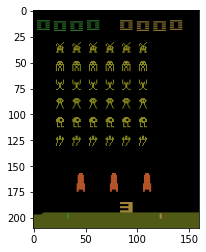

In [6]:
observation = env.reset()
# Game Screen
for i in range(11):
  if i > 9:
    plt.imshow(observation)
    plt.show()
  observation, _, _, _ = env.step(1)

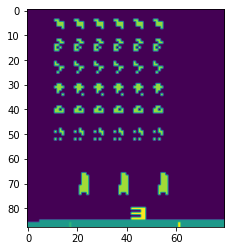

In [7]:
# Preprocessed Game Screen
obs_preprocessed = preprocess_frame(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()

# Evaluation

In [0]:
# **** Caution: Do not modify this cell ****
# initialize total reward across episodes
cumulative_reward = 0
episode = 0

def evaluate(episodic_reward):
  '''
  Takes in the reward for an episode, calculates the cumulative_avg_reward
    and logs it in wandb. If episode > 100, stops logging scores to wandb.
    Called after playing each episode. See example below.

  Arguments:
    episodic_reward - reward received after playing current episode
  '''
  global episode
  global cumulative_reward
  episode += 1
  print("Episode: %d"%(episode))

  # your models will be evaluated on 100-episode average reward
  # therefore, we stop logging after 100 episodes
  if (episode > 100):
    print("Scores from episodes > 100 won't be logged in wandb.")
    return

  # log total reward received in this episode to wandb
  wandb.log({'episodic_reward': episodic_reward})

  # add reward from this episode to cumulative_reward
  cumulative_reward += episodic_reward

  # calculate the cumulative_avg_reward
  # this is the metric your models will be evaluated on
  cumulative_avg_reward = cumulative_reward/episode
  print("episode_reward:",episodic_reward,"avg_reward:",cumulative_avg_reward)

  # log cumulative_avg_reward over all episodes played so far
  wandb.log({'cumulative_avg_reward': cumulative_avg_reward})

### Play a random game, log reward and gameplay video in wandb

In this section we'll show you how to save a model in Weights & Biases. This is necessary in order for us to evaluate your model.

Let's train a very basic model to start.

In [0]:
class SumTreeNode:
  def __init__(self, left, right, is_leaf=False, idx=None):
    self.left = left
    self.right = right
    self.is_leaf = is_leaf
    self.value = 0
    self.idx = idx
    self.parent = None
    if not self.is_leaf:
      self.value = self.left.value + self.right.value
    if left is not None:
      left.parent = self
    if right is not None:
      right.parent = self

  @classmethod
  def create_leaf_node(cls,value,idx):
    leaf = cls(None,None,is_leaf=True,idx=idx)
    leaf.value = value
    return leaf

class SumTree:
  def __init__(self, inputs):
    nodes = [SumTreeNode.create_leaf_node(val, idx) for idx, val in enumerate(inputs)]
    self.leaf_nodes = nodes
    while len(nodes) > 1:
      nodes_itr = iter(nodes)
      nodes = [SumTreeNode(*pair) for pair in zip(nodes_itr, nodes_itr)]
    self.base_node = nodes[0]

  def retrieve_node(self, value):
    val = value
    node = self.base_node
    while not node.is_leaf:
      if node.left.value >= val:
        node = node.left
      else:
        val -= node.left.value
        node = node.right
    return node

  def update(self, idx, new_value):
    node = self.leaf_nodes[idx]
    change = new_value - node.value
    node.value = new_value
    while node.parent is not None:
      node = node.parent
      node.value += change

  def get_base_node_value(self):
    return self.base_node.value

In [0]:
class PrioritizedExperienceReplay(object):
  def __init__(self, max_size=1000000, train_min_frames=50000, train_max_frames=6000000, batch_size=32, state_frames_size=4, state_frame_height=88, state_frame_width=80):
    self.max_size = max_size
    self.train_min_frames = train_min_frames
    self.train_max_frames = train_max_frames
    self.frame_height = state_frame_height
    self.frame_width = state_frame_width
    self.frame_history = state_frames_size
    self.batch_size = batch_size    
    self.current_idx = 0
    self.total_count = 0

    self.beta_start = 0.4
    self.beta_end = 1
    self.beta_slope = (self.beta_end - self.beta_start) / self.train_max_frames
    self.beta_intercept = self.beta_start - (self.beta_slope * self.train_min_frames)
    self.alpha = 0.6
    self.min_priority = 0.01
    self.sum_tree = SumTree([0 for i in range(self.max_size)])

    self.actions = np.empty(self.max_size, dtype=np.int8)
    self.rewards = np.empty(self.max_size, dtype=np.float32)
    self.terminal_flags = np.empty(self.max_size, dtype=np.bool)
    self.image_frames = np.empty((self.max_size, self.frame_height, self.frame_width), dtype=np.uint8)

    self.states = np.empty((self.batch_size, self.frame_history, self.frame_height, self.frame_width), dtype=np.uint8)
    self.new_states = np.empty((self.batch_size, self.frame_history, self.frame_height, self.frame_width), dtype=np.uint8)
    self.batch_indices = np.empty(self.batch_size, dtype=np.int32)
    self.importance_weights = np.empty(self.batch_size, dtype=np.float32)

  def get_adjusted_priority(self, priority_value):
    return np.power(priority_value + self.min_priority, self.alpha)

  def add_experience(self, frame, action, reward, terminal_flag, priority_value):
    self.image_frames[self.current_idx, ...] = frame
    self.actions[self.current_idx] = action
    self.rewards[self.current_idx] = reward
    self.terminal_flags[self.current_idx] = terminal_flag    
    self.sum_tree.update(self.current_idx, self.get_adjusted_priority(priority_value))
    self.current_idx +=1 

    if self.current_idx >= self.max_size:
      self.current_idx = 0

    if self.total_count + 1 < self.max_size:
      self.total_count += 1
    else:
      self.total_count = self.max_size

  # update_batch() should be called only after get_mini_batch() is invoked
  # else td_error will be updated for wrong batch_indices
  def update_batch(self, td_error):
    for idx, batch_idx in enumerate(self.batch_indices):
      self.sum_tree.update(batch_idx, self.get_adjusted_priority(td_error[idx]))  

  def get_indices_and_weights(self, frame_nos):    
    base_node_val = self.sum_tree.get_base_node_value()
    every_range_len = base_node_val / self.batch_size
    for i in range(self.batch_size):      
      while True:
        sample_priority_val = (random.random() * every_range_len) + (i * every_range_len)
        sample_node = self.sum_tree.retrieve_node(sample_priority_val) 
        if sample_node.idx < self.frame_history:
          continue       
        if sample_node.idx >= self.total_count:
          continue
        if sample_node.idx >= self.current_idx and (sample_node.idx - self.frame_history) <= self.current_idx:
          continue
        if self.terminal_flags[sample_node.idx - self.frame_history:sample_node.idx].any():
          continue
        break
      self.batch_indices[i] = sample_node.idx
      norm_probability = sample_node.value / base_node_val
      self.importance_weights[i] = (self.total_count * norm_probability)
    beta = self.beta_intercept + (self.beta_slope * frame_nos)
    self.importance_weights = np.power(self.importance_weights, -beta)
    self.importance_weights = self.importance_weights / np.max(self.importance_weights)

  def get_mini_batch(self, frame_nos):
    if self.total_count < self.frame_history:
      raise("Insufficient experience")    
    self.get_indices_and_weights(frame_nos)
    for idx, batch_idx in enumerate(self.batch_indices):
      self.states[idx] = self.image_frames[batch_idx - self.frame_history:batch_idx, ...]
      self.new_states[idx] = self.image_frames[(batch_idx - self.frame_history)+1:batch_idx+1, ...]
    return np.transpose(self.states, axes=(0,2,3,1)), self.actions[self.batch_indices], self.rewards[self.batch_indices], np.transpose(self.new_states, axes=(0,2,3,1)), self.terminal_flags[self.batch_indices], self.importance_weights

In [0]:
class DuelingDoubleDQNModel(tf.keras.Model):
  def __init__(self, action_size, hidden_units=512, batch_size=32, state_frames_size=4, state_frame_height=88, state_frame_width=80):
    super(DuelingDoubleDQNModel, self).__init__()      
    self.action_size = action_size
    self.batch_size = batch_size
    self.hidden_units = hidden_units    
    self.state_frames_size = state_frames_size
    self.state_frame_height = state_frame_height
    self.state_frame_width = state_frame_width
        
    self.input_layer = tf.keras.layers.InputLayer(input_shape=[self.state_frame_height, self.state_frame_width, self.state_frames_size], batch_size=self.batch_size, name="input")
    self.norm_input = tf.keras.layers.Lambda(lambda x : x / 255.0)               
    self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=[8,8], strides=4,
                                        kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2),
                                        padding="valid", activation=tf.keras.activations.relu, use_bias=False, name='conv1')
    self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=[4,4], strides=2,
                                        kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2),
                                        padding="valid", activation=tf.keras.activations.relu, use_bias=False, name='conv2')
    self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], strides=1,
                                        kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2),
                                        padding="valid", activation=tf.keras.activations.relu, use_bias=False, name='conv3')
    self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], strides=1,
                                        kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2),
                                        padding="valid", activation=tf.keras.activations.relu, use_bias=False, name='conv4')    
    self.flatten = tf.keras.layers.Flatten()
    self.value_dense = tf.keras.layers.Dense(units=hidden_units, activation=tf.keras.activations.relu, 
                                             kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2), name='value_dense')
    self.advantage_dense = tf.keras.layers.Dense(units=hidden_units, activation=tf.keras.activations.relu, 
                                             kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2), name='advantage_dense')
    self.value_out = tf.keras.layers.Dense(units=1, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2), name='value_out')    
    self.advantage_out = tf.keras.layers.Dense(units=self.action_size, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2), name='advantage_out')
    self.advantage_reduce = tf.keras.layers.Lambda(lambda x : x - tf.reduce_mean(x))
    self.Q_values = tf.keras.layers.Add()

  @tf.function
  def call(self, state_frames):
    inputs = self.input_layer(tf.cast(state_frames, tf.float32))
    norm_inputs = self.norm_input(inputs)    
    conv_output1 = self.conv1(norm_inputs)
    conv_output2 = self.conv2(conv_output1)
    conv_output3 = self.conv3(conv_output2)
    conv_output4 = self.conv4(conv_output3)
    flatten_output = self.flatten(conv_output4)
    val_dense = self.value_dense(flatten_output)
    adv_dense = self.advantage_dense(flatten_output)
    val_out = self.value_out(val_dense)
    adv_out = self.advantage_out(adv_dense)
    norm_adv_out = self.advantage_reduce(adv_out)    
    q_vals = self.Q_values([val_out, norm_adv_out])        
    return q_vals

In [0]:
class DuelingDoubleDQN:
  def __init__(self, epsilon_greedy, action_size, hidden_units=512, learning_rate=0.0000625, batch_size=32, state_frames_size=4, state_frame_height=88, state_frame_width=80):    
    self.epsilon_greedy = epsilon_greedy
    self.action_size = action_size    
    self.model = DuelingDoubleDQNModel(action_size, hidden_units, batch_size, state_frames_size, state_frame_height, state_frame_width)
    self.loss = tf.keras.losses.Huber()
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    
  
  def get_Q_values(self, input):
    return self.model(input)    
  
  def train(self, states, actions, target_Q, importance_sampling_weights):        
    with tf.GradientTape() as tape:
      predicted_Q_values = self.get_Q_values(states)
      predicted_Q = tf.reduce_sum(tf.multiply(predicted_Q_values, tf.one_hot(actions, self.action_size, dtype=tf.float32)), axis=1)
      predicted_Q = tf.expand_dims(predicted_Q, 1)
      target_Q = tf.convert_to_tensor(target_Q)
      target_Q = tf.expand_dims(target_Q, 1)      
      importance_sampling_weights = tf.convert_to_tensor(importance_sampling_weights)            
      loss = self.loss.__call__(y_true=target_Q, y_pred=predicted_Q, sample_weight=importance_sampling_weights)
    variables = self.model.trainable_variables    
    gradients = tape.gradient(loss, variables)    
    self.optimizer.apply_gradients(zip(gradients, variables))
    return predicted_Q_values, loss

  def get_action(self, input, frame_nos, evaluation=False):
    Q_Values = self.get_Q_values(np.expand_dims(input, axis=0))
    epsilon = self.epsilon_greedy.get_epsilon(frame_nos, evaluation)
    if np.random.rand(1) < epsilon:
      return np.random.randint(0, self.action_size), Q_Values
    else:            
      best_action = tf.argmax(Q_Values, 1)
      return best_action, Q_Values      

  def copy_weights(self, main_dqn):
    variables_1 = self.model.trainable_variables
    variables_2 = main_dqn.model.trainable_variables
    for v1, v2 in zip(variables_1, variables_2):
      v1.assign(v2.numpy())

  def save_model(self, name):
    self.model.save(name)

  def load_model(self, name):
    self.model = tf.keras.models.load_model(name)
    print(self.model.summary())

In [0]:
def huber_loss(loss):
  return 0.5 * loss ** 2 if abs(loss) < 1.0 else abs(loss) - 0.5

def get_target_Q(main_dqn, target_dqn, batch_size, gamma, new_states, rewards, terminal_flags):
  main_dqn_Q = main_dqn.get_Q_values(new_states)
  arg_Q_max = tf.argmax(main_dqn_Q, 1)
  target_dqn_Q = target_dqn.get_Q_values(new_states)  
  double_Q = target_dqn_Q.numpy()[range(0,batch_size), arg_Q_max]
  target_Q = rewards + (gamma * double_Q * (1 - terminal_flags))
  return target_Q

def get_td_error(target_Q, predicted_Q, actions, batch_size):  
  td_error = [huber_loss(target_Q[i] - predicted_Q.numpy()[i, actions[i]]) for i in range(batch_size)]
  return td_error

def train_main_dqn(main_dqn, target_dqn, experience_replay, batch_size, gamma, frame_nos):
  states, actions, rewards, new_states, terminal_flags, imp_weights = experience_replay.get_mini_batch(frame_nos)      
  target_Q = get_target_Q(main_dqn, target_dqn, batch_size, gamma, new_states, rewards, terminal_flags)  
  predicted_Q, loss = main_dqn.train(states, actions, target_Q, imp_weights)
  # Calculate the TD-Error for updating the experience replay priorities  
  # Update the experience replay with TD-error
  experience_replay.update_batch(get_td_error(target_Q, predicted_Q, actions, batch_size))
  return loss

In [0]:
class epsilonGreedy(object):
  def __init__(self, replay_min_frames, replay_max_frames, train_max_frames):    
    self.epsilon_start = 1.0
    self.epsilon_end = 0.1
    self.epsilon_min = 0.01
    self.epsilon_eval = 0.05
    self.replay_max_frames = replay_max_frames
    self.replay_min_frames = replay_min_frames
    self.train_max_frames = train_max_frames
    self.epsilon_slope = -(self.epsilon_start - self.epsilon_end)/self.replay_max_frames
    self.epsilon_intercept = self.epsilon_start - (self.epsilon_slope * self.replay_min_frames)
    self.epsilon_slope_2 = -(self.epsilon_end - self.epsilon_min)/(self.train_max_frames - self.replay_max_frames - self.replay_min_frames)
    self.epsilon_intercept_2 = self.epsilon_min - (self.epsilon_slope_2 * self.train_max_frames)  

  def get_epsilon(self, frame_nos, evaluation=False):
    epsilon = 0
    if evaluation:
      epsilon = self.epsilon_eval
    elif frame_nos < self.replay_min_frames:
      epsilon = self.epsilon_start
    elif frame_nos >= self.replay_min_frames and frame_nos < (self.replay_min_frames + self.replay_max_frames):
      epsilon = (frame_nos * self.epsilon_slope) + self.epsilon_intercept
    elif frame_nos >= (self.replay_min_frames + self.replay_max_frames):
      epsilon = (frame_nos * self.epsilon_slope_2) + self.epsilon_intercept_2
    return epsilon    

In [0]:
class Atari_Env(object):
  def __init__(self, atari_env, no_op_steps = 30, frame_history = 4):
    self.env = gym.make(atari_env)
    self.state = None
    self.remaining_lives = 0
    self.no_op_steps = no_op_steps
    self.frame_history = frame_history

  def reset(self, evaluation=False):
    frame = self.env.reset()
    self.remaining_lives = 0
    terminal_life_lost = True
    if evaluation:
      for _ in range(random.randint(1, self.no_op_steps)):
        frame, _, _, _ = self.env.step(0) #Do nothing
    processed_frame = preprocess_frame(frame)    
    self.state = np.repeat(processed_frame, self.frame_history, axis=2)
    return terminal_life_lost

  def step(self, action):    
    new_frame, reward, terminal, info = self.env.step(action)
    if info['ale.lives'] < self.remaining_lives:
      terminal_life_lost = True
    else:
      terminal_life_lost = terminal
    self.remaining_lives = info['ale.lives']
    processed_new_frame = preprocess_frame(new_frame)
    new_state = np.append(self.state[:,:,1:], processed_new_frame, axis=2)
    self.state = new_state
    return processed_new_frame, reward, terminal, terminal_life_lost, new_frame

  def eval_reset(self):
    frame = self.env.reset()    
    for _ in range(random.randint(0, self.no_op_steps)):
      frame, _, _, _ = self.env.step(0)
    processed_frame = preprocess_frame(frame)    
    self.state = np.repeat(processed_frame, self.frame_history, axis=2)
    return self.state

  def eval_step(self, action, frame_skip):
    prev_frame = None
    new_frame, reward, terminal, _ = self.env.step(action)        
    for _ in range(1, frame_skip):
      if not terminal:
        prev_frame = new_frame
        new_frame, r, terminal, _ = self.env.step(action)
        reward += r

    if prev_frame is not None:
      new_frame = np.maximum.reduce([new_frame, prev_frame])    
        
    processed_new_frame = preprocess_frame(new_frame)
    self.state = np.append(self.state[:,:,1:], processed_new_frame, axis=2)
    return self.state, reward, terminal            

In [0]:
def clip_reward(reward):
  if reward > 0:
    return 1
  elif reward == 0:
    return 0
  else:
    return -1

In [0]:
tf.keras.backend.clear_session()

MAX_EPISODE_FRAMES = 18000
TARGET_NETWORK_UPDATE_FREQ = 10000
GAMMA = 0.99
EVALUATION_FREQUENCY = 200000
EVALUATION_STEPS = 10000
EXPERIENCE_REPLAY_MIN_SIZE = 50000
EXPERIENCE_REPLAY_MAX_SIZE = 1000000
MAX_FRAMES = 3000000
NO_OP_STEPS = 30
UPDATE_FREQ = 4
HIDDEN = 512
LEARNING_RATE = 0.0000625
BATCH_SIZE = 32

The below code block is used to train the model. Skip this in-case of evaluation of a pre-trained model.

In [0]:
def execute_training():
  # initialize a new wandb run
  wandb.init(project="qualcomm")
  print("Wandb Run Dir:",wandb.run.dir)
  atari_env = Atari_Env("SpaceInvaders-v0", NO_OP_STEPS)
  experience_memory = PrioritizedExperienceReplay(max_size=EXPERIENCE_REPLAY_MAX_SIZE, train_min_frames=EXPERIENCE_REPLAY_MIN_SIZE, train_max_frames=MAX_FRAMES, batch_size=BATCH_SIZE)  
  epsilon_greedy = epsilonGreedy(replay_min_frames=EXPERIENCE_REPLAY_MIN_SIZE, replay_max_frames=EXPERIENCE_REPLAY_MAX_SIZE, train_max_frames=MAX_FRAMES)
  main_dqn = DuelingDoubleDQN(epsilon_greedy, atari_env.env.action_space.n, hidden_units=HIDDEN, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
  target_dqn = DuelingDoubleDQN(epsilon_greedy, atari_env.env.action_space.n, hidden_units=HIDDEN, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
  frame_nos = 0
  total_train_rewards = []
  total_train_loss = []

  while frame_nos < MAX_FRAMES:
    epoch_frame = 0
    while epoch_frame < EVALUATION_FREQUENCY:
      ### TRAINING ###
      terminal_life_lost = atari_env.reset(evaluation=False)
      episode_reward = 0
      episode_loss = 0
      for _ in range(MAX_EPISODE_FRAMES):
        action, predicted_Q = main_dqn.get_action(atari_env.state, frame_nos, evaluation=False)
        old_state = atari_env.state
        processed_new_frame, reward, terminal, terminal_life_lost, _ = atari_env.step(action)
        frame_nos += 1
        epoch_frame += 1
        episode_reward += reward        

        if frame_nos % UPDATE_FREQ == 0 and frame_nos > EXPERIENCE_REPLAY_MIN_SIZE:
          loss = train_main_dqn(main_dqn, target_dqn, experience_memory, batch_size=BATCH_SIZE, gamma=GAMMA, frame_nos=frame_nos)          
          episode_loss += loss.numpy()

        if frame_nos < EXPERIENCE_REPLAY_MIN_SIZE:
          experience_memory.add_experience(processed_new_frame[:,:,0], action, clip_reward(reward), terminal_life_lost, reward)
        else:
          if predicted_Q is None:
            predicted_Q = main_dqn.get_Q_values(np.expand_dims(old_state, axis=0)) 
          target_Q = get_target_Q(main_dqn, target_dqn, batch_size=1, gamma=GAMMA, new_states=np.expand_dims(atari_env.state, axis=0), rewards=reward, terminal_flags=terminal)
          td_error = get_td_error(target_Q, predicted_Q, [action], batch_size=1)
          experience_memory.add_experience(processed_new_frame[:,:,0], action, clip_reward(reward), terminal_life_lost, td_error[0])
        
        if frame_nos % TARGET_NETWORK_UPDATE_FREQ and frame_nos > EXPERIENCE_REPLAY_MIN_SIZE:
          target_dqn.copy_weights(main_dqn)

        if terminal:
          terminal = False
          break

      total_train_rewards.append(episode_reward)
      total_train_loss.append(episode_loss)
      #print("Train Episode:", len(total_train_rewards), "frame_nos:", frame_nos,"episode_reward:", episode_reward, "episode_loss:",episode_loss)

    ### EVALUATION ###
    terminal = True
    total_eval_rewards = []
    for _ in range(EVALUATION_STEPS):
      if terminal:
        terminal_life_lost = atari_env.reset(evaluation=True)
        episode_reward = 0
        terminal = False

      action, _ = main_dqn.get_action(atari_env.state, frame_nos, evaluation=True)
      processed_new_frame, reward, terminal, terminal_life_lost, _ = atari_env.step(action)
      episode_reward += reward

      if terminal:
        total_eval_rewards.append(episode_reward)        
        print("Eval Episode:", len(total_eval_rewards), "Episode Reward:", episode_reward, "Avg Reward:", np.mean(total_eval_rewards))

    wandb.log({'cumulative_avg_reward': np.mean(total_eval_rewards)})
    # Save model on gdrive
    print("Saving model at frame nos:",frame_nos)
    gdrive_model_name = 'DDDQN_Model_PER_Final'
    main_dqn.save_model("/content/gdrive/My Drive/" + gdrive_model_name)

  # Save model on wandb
  main_dqn.save_model(os.path.join(wandb.run.dir,gdrive_model_name))

execute_training()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Wandb Run Dir: /content/wandb/run-20200425_214307-1b578d1f


/usr/local/lib/python3.6/dist-packages/gym/envs/atari/atari_env.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  action = self._action_set[a]


Eval Episode: 1 Episode Reward: 125.0 Avg Reward: 125.0
Eval Episode: 2 Episode Reward: 210.0 Avg Reward: 167.5
Eval Episode: 3 Episode Reward: 275.0 Avg Reward: 203.33333333333334
Eval Episode: 4 Episode Reward: 200.0 Avg Reward: 202.5
Eval Episode: 5 Episode Reward: 350.0 Avg Reward: 232.0
Eval Episode: 6 Episode Reward: 110.0 Avg Reward: 211.66666666666666
Eval Episode: 7 Episode Reward: 180.0 Avg Reward: 207.14285714285714
Eval Episode: 8 Episode Reward: 145.0 Avg Reward: 199.375
Saving model at frame nos: 200550
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/DDDQN_Model_PER_Final/assets
Eval Episode: 1 Episode Reward: 100.0 Avg Reward: 100.0
Eval Episode: 2 Episode Reward: 95.0 Avg Reward: 97.5
Eval Episode: 3 Episode Reward: 145.0 Avg Reward: 113.33333333333333
Eval Episode: 4 Episode Reward: 80.0 Avg Reward: 105.0
Eval Episode: 5 Episode Reward: 195.0 Avg Reward: 123.0
Eval Episode: 6 E

requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/raghmura/qualcomm/1b578d1f/file_stream. args: ('https://api.wandb.ai/files/raghmura/qualcomm/1b578d1f/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1082, 'content': ['{"system.gpu.0.gpu": 11.33, "system.gpu.0.memory": 1.0, "system.gpu.0.memoryAllocated": 4.26, "system.gpu.0.temp": 41.0, "system.gpu.0.powerWatts": 34.97, "system.gpu.0.powerPercent": 13.99, "system.cpu": 54.82, "system.memory": 72.29, "system.disk": 48.3, "system.proc.memory.availableMB": 3612.62, "system.proc.memory.rssMB": 9473.86, "system.proc.memory.percent": 72.76, "system.proc.cpu.threads": 34.0, "system.network.sent": 43420809, "system.network.recv": 7806662, "_wandb": true, "_timestamp": 1587886901, "_runtime": 36131}\n']}}}}
requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/rag

Eval Episode: 1 Episode Reward: 540.0 Avg Reward: 540.0
Eval Episode: 2 Episode Reward: 100.0 Avg Reward: 320.0
Eval Episode: 3 Episode Reward: 60.0 Avg Reward: 233.33333333333334
Eval Episode: 4 Episode Reward: 115.0 Avg Reward: 203.75
Eval Episode: 5 Episode Reward: 105.0 Avg Reward: 184.0
Eval Episode: 6 Episode Reward: 75.0 Avg Reward: 165.83333333333334
Eval Episode: 7 Episode Reward: 195.0 Avg Reward: 170.0
Eval Episode: 8 Episode Reward: 250.0 Avg Reward: 180.0
Eval Episode: 9 Episode Reward: 130.0 Avg Reward: 174.44444444444446
Eval Episode: 10 Episode Reward: 80.0 Avg Reward: 165.0
Eval Episode: 11 Episode Reward: 320.0 Avg Reward: 179.0909090909091
Eval Episode: 12 Episode Reward: 70.0 Avg Reward: 170.0
Saving model at frame nos: 1403366
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/DDDQN_Model_PER_Final/assets
Eval Episode: 1 Episode Reward: 320.0 Avg Reward: 320.0
Eval Episode: 2 Episode Reward: 530.0 Avg Reward: 425.0
Eval Episode: 3 Episode Reward: 130.0 Avg

The below code block to be used to evaluate the trained model -

In [0]:
# **** Caution: Do not modify this cell ****
# initialize total reward across episodes
cumulative_reward = 0
episode = 0

def evaluate(episodic_reward, reset=False):
  '''
  Takes in the reward for an episode, calculates the cumulative_avg_reward
    and logs it in wandb. If episode > 100, stops logging scores to wandb.
    Called after playing each episode. See example below.

  Arguments:
    episodic_reward - reward received after playing current episode
  '''
  global episode
  global cumulative_reward
  if reset:
    cumulative_reward = 0
    episode = 0
    
  episode += 1
  print("Episode: %d"%(episode))

  # your models will be evaluated on 100-episode average reward
  # therefore, we stop logging after 100 episodes
  if (episode > 100):
    print("Scores from episodes > 100 won't be logged in wandb.")
    return

  # log total reward received in this episode to wandb
  wandb.log({'episodic_reward': episodic_reward})
  print("episodic_reward ", episodic_reward)

  # add reward from this episode to cumulative_reward
  cumulative_reward += episodic_reward

  # calculate the cumulative_avg_reward
  # this is the metric your models will be evaluated on
  cumulative_avg_reward = cumulative_reward/episode

  # log cumulative_avg_reward over all episodes played so far
  wandb.log({'cumulative_avg_reward': cumulative_avg_reward})
  print('cumulative_avg_reward ', cumulative_avg_reward)

  return cumulative_avg_reward

In [27]:
from numpy.random import seed

cumulative_avg_rewards = []
total_episode_rewards = {}
total_avg_rewards = {}
for seed_ in [100]:
  log_name_1 = "episode_reward-" + str(seed_)
  log_name_2 = "cumulative_avg_reward-" + str(seed_)
  seed_run_episode_reward = []
  seed_run_avg_rewards = []
  seed(seed_)
  tf.random.set_seed(seed_)
  print("Seed: ",seed_)

  # Load the trained model
  atari_env = Atari_Env("SpaceInvaders-v0", NO_OP_STEPS)  
  epsilon_greedy = epsilonGreedy(replay_min_frames=EXPERIENCE_REPLAY_MIN_SIZE, replay_max_frames=EXPERIENCE_REPLAY_MAX_SIZE, train_max_frames=MAX_FRAMES)
  trained_dqn = DuelingDoubleDQN(epsilon_greedy, atari_env.env.action_space.n, hidden_units=HIDDEN, learning_rate=LEARNING_RATE)   
  # load the model
  model_name = "/content/gdrive/My Drive/DDDQN_Model_PER_Final"
  trained_dqn.load_model(model_name)

  # initialize a new wandb run
  wandb.init(project="qualcomm")
  print("Wandb Run Dir:",wandb.run.dir)

  # define hyperparameters
  wandb.config.episodes = 100  

  # record gameplay video
  display = Display(visible=0, size=(1400, 900))
  display.start()

  highest_score = 0
  total_Q = np.zeros([6])
  q_values = np.zeros([6])
  # run for 100 episodes
  for i in range(wandb.config.episodes):  
  #for i in range(100):  
    # Set reward received in this episode = 0 at the start of the episode
    episodic_reward = 0
    reset = False

    # record a video of the game using wrapper
    atari_env.env = gym.wrappers.Monitor(atari_env.env, './video', force=True)        

    terminal = False
    state = atari_env.eval_reset()
    action_count = 0
    while not terminal:
      # get prediction for next action from model            
      action, q_vals = trained_dqn.get_action(state, 0, evaluation=True)      
      state, reward, terminal = atari_env.eval_step(action, frame_skip=3)      
      episodic_reward += reward
      action_count += 1           
      q_values += q_vals.numpy()[0]    
    q_values = q_values / action_count
    total_Q += q_values
    q_values = np.zeros([6])
      
    # call evaluation function - takes in reward received after playing an episode
    # calculates the cumulative_avg_reward over 100 episodes & logs it in wandb
    if(i==0):
      reset = True

    cumulative_avg_reward = evaluate(episodic_reward, reset)    
    seed_run_episode_reward.append(episodic_reward)
    seed_run_avg_rewards.append(cumulative_avg_reward)
    # your models will be evaluated on 100-episode average reward
    # therefore, we stop logging after 100 episodes
    if (i >= 99):
      cumulative_avg_rewards.append(cumulative_avg_reward)      
      break
  
    atari_env.env.close()

    # render gameplay video, if the scrore is higher than previous recorded video's score
    if (highest_score < episodic_reward): 
      highest_score = episodic_reward   
      mp4list = glob.glob('video/*.mp4')
      if len(mp4list) > 0:
        print(len(mp4list))
        mp4 = mp4list[-1]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)

        # log gameplay video in wandb
        gameplay = "gameplay-"  + str(seed_)
        wandb.log({gameplay: wandb.Video(mp4, fps=4, format="gif")})

        # display gameplay video
        ipythondisplay.display(HTML(data='''<video alt="" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))        
    
total_Q = total_Q / wandb.config.episodes    
for q in range(atari_env.env.action_space.n):
  wandb.log({'Avg_Q_Values': total_Q[q]})           

Output hidden; open in https://colab.research.google.com to view.